# L-Dopa Subchallenge 2 
## Semi-supervised learning based on surprise features 
### AbilityLab Team Submission code
Luca Lonini, Nicholas Shawen, Andrew Dai, Konrad Kording, Arun Jayaraman

In [1]:
import pandas as pd
import json
import numpy as np
import pickle #to save files

from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.svm import SVC, OneClassSVM

from sklearn.metrics import precision_score, recall_score,f1_score

import nolds
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.core.debugger import Tracer
import synapseclient
syn=synapseclient.login()

Welcome, Luca Lonini!



## Helper fcns

In [3]:
#feature extraction
#INPUT: raw x,y,z accelerometer data (dataframe)
def feature_extraction(rawdata):
    
    #drop time and magnitude feature
    rawdata_wtime = rawdata.copy()
    rawdata=rawdata.iloc[:,1:4]
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew',
                    'PSD_kur','jerk_mean','jerk_std','jerk_skew','jerk_kur']#,'Sen_X','Sen_Y','Sen_Z','Sen_FFTX','Sen_FFTY','Sen_FFTZ']
    

    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    #extract features on current clip

    #Energy of signal on each axis
    E = np.asarray(np.sum(rawdata**2,axis=0))

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis
    mean = np.asarray(np.mean(rawdata,axis=0))
    var = np.asarray(np.std(rawdata,axis=0))
    sk = skew(rawdata)
    kurt = kurtosis(rawdata)

    #Cross-correlation between axes pairs
    xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
    xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

    xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
    xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

    xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
    xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

    #pack xcorr features
    xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
    xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])
    
    #jerk moments on magnitude
    jerk = rawdata.iloc[:,-1].diff().values
    jerk_moments = np.array([np.nanmean(jerk),np.nanstd(jerk),skew(jerk[~np.isnan(jerk)]),kurtosis(jerk[~np.isnan(jerk)])])

    #Dominant freq and relative magnitude (on acc magnitude)
    Pxx = power_spectra_welch(rawdata_wtime,fm=1,fM=10)
    domfreq = np.asarray([Pxx.iloc[:,-1].argmax()]) 
    Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total
    
    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx.values),np.nanstd(Pxx.values),skew(Pxx.values),kurtosis(Pxx.values)])

    #sample entropy raw data and FFT - COMPUTATIONALLY EXPENSIVE - TAKE OUT FOR NOW
    sH_raw = []; sH_fft = []
    #on magnitude
#     x = rawdata.iloc[:,-1]
#     n = len(x) #number of samples in clip
#     Fs = np.mean(1/(np.diff(x.timestamp))) #sampling rate in clip
#     sH_raw=nolds.sampen(x) #samp entr raw magnitude
#     f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#     sH_fft=(nolds.sampen(Pxx_den)) #samp entr fft
    #Sample entropy on each axis
#     for a in range(3):
#         x = rawdata.iloc[:,a]
#         n = len(x) #number of samples in clip
#         Fs = np.mean(1/(np.diff(rawdata_wtime.timestamp))) #sampling rate in clip
#         sH_raw.append(nolds.sampen(x)) #samp entr raw data
#         f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#         sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

    #Assemble features in array
    X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel,Pxx_moments,jerk_moments))
#                 X = X.reshape(1,X.shape[0])
    features.append(X)

    F = np.asarray(features) #feature matrix for all clips from current trial
    return F,features_list


#EXTRACT DATA WINDOWS FROM RAW DATA RECORDINGS
def gen_clips(rawdata,clipsize=5,overlap=0,interp=False):
    
    len_tol = 0.8   #% of the intended clipsize below which clip is not used (deprecated for now)
    #reindex time (relative to start)
    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    #create clips data
    deltat = np.median(np.diff(rawdata.timestamp))
    idx = np.arange(0,rawdata.timestamp.iloc[-1],clipsize*(1-overlap))
    clips = []
    for i in idx:
        c = rawdata[(rawdata.timestamp>=i) & (rawdata.timestamp<i+clipsize)]
        if interp:
            if len(c) == 250:
                clips.append(c)
            #resample clip if not enough samples are there
            elif (len(c) >200) & (len(c)<250): #for now hard code clip size (enforce 250 samples)
                t = c.timestamp.values
                tnew = np.linspace(t[0],t[-1],250)  
                x_res = resample(c.iloc[:,1].values,num,tnew)[0]
                y_res = resample(c.iloc[:,2].values,num,tnew)[0]
                z_res = resample(c.iloc[:,3].values,num,tnew)[0]
                mag_res = resample(c.iloc[:,4].values,num,tnew)[0]
                cres = pd.DataFrame(data=np.vstack((tnew,x_res,y_res,z_res,mag_res)).T,columns=list(c.columns))
                clips.append(cres)
        else:
            if len(c) > 10: #at least n data points in clip
                clips.append(c)
#         if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
    return clips


    
#PSD on magnitude using Welch method
def power_spectra_welch(rawdata,fm,fM):
    x = rawdata.iloc[:,-1]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=min(256,n))
    #return PSD in desired interval of freq
    inds = (f<=fM)&(f>=fm)
    f=f[inds]
    Pxx_den=Pxx_den[inds]
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])

    return Pxxdf

    
#highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
def filter_signal(rawdata,cutoff=0.75,ftype='highpass',order=4):

    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    x = rawdata.iloc[:,1:].values
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate    
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
    b,a = butter(order,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    t = np.expand_dims(t,axis=1)
    rawdatafilt = pd.DataFrame(data=np.hstack((t,xfilt)),columns=rawdata.columns)
    return rawdatafilt

#PERFORMS LEAVE ONE SUBJECT OUT CROSS VALIDATION TO EVALUATE PERFORMANCE OF MODELS AND STORE OUTPUT POSTERIOR 
#PROBABILITIES OF CLASSIFIERS TO BE USED AS FEATURES
#X,y are numpy arrays with features and target
#Fnew is dataframe storing the posteriors (new features)
#returns mean feature importance
def LOSOCV(X,y,groups,models,Fnew):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for clf,model_name in models:

        Prec_all=[]; Rec_all=[]; f1_train=[]; Posteriors=[] 

        print('Training %s'%model_name)
        
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte) #posterior scores on left out subject
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            f1_train.append(f1_score(ytr,ypred_train))

            #compute Sens and Spec for current subject and classifier
            if np.sum(yte==1)>0:                    
                Prec = precision_score(yte,ypred)
                Rec = recall_score(yte,ypred)
            else:
                print('no positive examples for current test subj')
                Sens = np.nan
            Prec_all.append(Prec); Rec_all.append(Rec)

            #store posteriors from current classifier and subject
#             Fnew[model_name].iloc[test_index]=yscore
            Fnew.loc[test_index,model_name]=yscore

            
        #mean across all subjects
        print(('%s, mean F1 on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(f1_train),2*np.nanstd(f1_train)/np.sqrt(len(f1_train))))
        print(('%s, mean Prec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Prec_all),2*np.nanstd(Prec_all)/np.sqrt(len(Prec_all))))
        print(('%s, mean Rec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Rec_all),2*np.nanstd(Rec_all)/np.sqrt(len(Rec_all))))

    return Fnew


#train classifiers on input training features Xtr and target ytr; 
#returns posterior predictions Fnew from each clf on test data X
def testdata_stacking(Xtr,ytr,Xte,models,Fnew):

    #train multiple classifiers
    for clf,model_name in models:
        print('Training %s'%model_name)
        clf.fit(Xtr,ytr)
        print('Computing prediction %s'%model_name)
        yscore = clf.predict_proba(Xte) #posterior scores on test data
        yscore = yscore[:,1]
        #store posteriors from current classifier on test data
        Fnew.loc[:,model_name]=yscore

    return Fnew


#REMOVE ROWS IN TRAIN AND TEST TABLES WITH EMPTY RECORDINGS
def findnanrows(df):

    empty_ind = []
    nans_found=0; n_empty=0
    for i in range(len(df)):

        f = df.iloc[i,:].path
        rawdata = pd.read_csv(f,sep='\t') #load file

        #remove nans
        rawdata = rawdata.astype('float64') #make sure everything is float
        if sum(np.sum(rawdata.isnull())) > 0:
            nans_found+=1 # of files w nans
            rawdata = rawdata.dropna() #drop nans

        #store row indices of empty files
        if rawdata.empty == True:
            n_empty+=1 #empty files
            empty_ind.append(i)
    print('Files w nans: %d'%nans_found)
    print('Files w 0 non-nan rows %d'%n_empty)
    return empty_ind

## Pull Train data (remove empty files rows)

In [5]:
symptom_score = 'bradykinesiaScore'
# symptom_score = 'dyskinesiaScore'
# symptom_score = 'tremorScore'

In [6]:
q_train = syn.tableQuery("SELECT * from syn10495809 where bradykinesiaScore is not null")
# q_train = syn.tableQuery("SELECT * from syn10495809 where dyskinesiaScore is not null")
# q_train = syn.tableQuery("SELECT * from syn10495809 where tremorScore is not null")

In [7]:
paths_train = syn.downloadTableColumns(q_train,'dataFileHandleId')

In [8]:
df_train = q_train.asDataFrame()
df_train['path']=df_train.dataFileHandleId.astype(str).map(paths_train)
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/28/17286028...
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/30/17286030...
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/34/17286034...
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/36/17286036...
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/42/17286042...


In [9]:
#remove nanrows
inds = findnanrows(df_train)
df_train=df_train.drop(df_train.index[inds])
y_train = df_train[symptom_score].values
len(df_train)

Files w nans: 190
Files w 0 non-nan rows 103


2913

## Pull test data

In [10]:
q_test = syn.tableQuery("SELECT * from syn10701954 where bradykinesiaScore = 'Score'")
# q_test = syn.tableQuery("SELECT * from syn10701954 where dyskinesiaScore = 'Score'")
# q_test = syn.tableQuery("SELECT * from syn10701954 where tremorScore = 'Score'")

In [11]:
paths_test = syn.downloadTableColumns(q_test,'dataFileHandleId')

In [12]:
df_test = q_test.asDataFrame()
df_test['path']=df_test.dataFileHandleId.astype(str).map(paths_test)
df_test.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
12959_10,17287630,GENEActiv,14_BOS,1,Boston,drnkg,1,Right,Score,NotApplicable,Score,/Users/luca/Projects/DREAMPD_Repo/Data/630/172...
12960_10,17287634,Pebble,14_BOS,1,Boston,drnkg,1,Left,Score,NotApplicable,Score,/Users/luca/Projects/DREAMPD_Repo/Data/634/172...
12961_10,17287639,GENEActiv,14_BOS,1,Boston,fldng,1,Right,Score,NotApplicable,Score,/Users/luca/Projects/DREAMPD_Repo/Data/639/172...
12962_10,17287642,Pebble,14_BOS,1,Boston,fldng,1,Left,Score,NotApplicable,Score,/Users/luca/Projects/DREAMPD_Repo/Data/642/172...
12964_10,17287650,Pebble,14_BOS,1,Boston,ftnl1,1,Left,Score,NotApplicable,Score,/Users/luca/Projects/DREAMPD_Repo/Data/650/172...


In [13]:
len(df_test)

1409

In [14]:
#remove nanrows
inds = findnanrows(df_test)
df_test=df_test.drop(df_test.index[inds])
len(df_test)

Files w nans: 125
Files w 0 non-nan rows 42


1367

## Extract metadata features and convert to numeric


In [68]:
# df = df_train
df = df_test #to run on df_test

In [69]:
len(df)

1367

In [70]:
X_meta = df[['dataFileHandleId','device','patient','session','site','task','visit','deviceSide']]
y_meta = df[symptom_score]

In [71]:
#encode cat vars with num
le = preprocessing.LabelEncoder()
X_meta_copy = X_meta.copy()
cat_cols = X_meta.select_dtypes(['object']).columns
for c in cat_cols:
    X_meta_copy[c]=le.fit_transform(X_meta[c])

In [72]:
X_meta=X_meta_copy
Metadata = X_meta_copy #store the metadata alone for later

In [73]:
#add task duration as another meta variable
#durations of tasks
c = 0
Dur = []
for f in df.path:
    rawdata = pd.read_csv(f,sep='\t')
    t = rawdata.timestamp
    t = t-t[0]
    rawdata.timestamp = t
    Dur.append(rawdata.timestamp.iloc[-1])
    c+=1
Dur = np.asarray(Dur)
X_meta['Duration']=Dur

In [67]:
#standardize duration (Train)
# scaler = StandardScaler()
# X_meta.iloc[:,-1]=scaler.fit_transform(X_meta.iloc[:,-1].values.reshape(-1,1))
#standardize duration (Test)
X_meta.iloc[:,-1]=scaler.transform(X_meta.iloc[:,-1].values.reshape(-1,1))

In [47]:
# #drop patient as metafeatures and store for later 
# groups = X_meta.patient.values
# X_meta=X_meta.drop('patient',axis=1)

In [48]:
X_meta.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration
12959_10,17287630,0,4,1,0,0,1,1,0.207830
12960_10,17287634,1,4,1,0,0,1,0,0.207830
12961_10,17287639,0,4,1,0,1,1,1,1.653407
12962_10,17287642,1,4,1,0,1,1,0,1.653407
12964_10,17287650,1,4,1,0,2,1,0,-0.786005


In [33]:
#save dataframe
# df.to_csv('./DataFrames/metadf_test_brady.csv')
# df.to_csv('./DataFrames/metadf_train_brady.csv')

In [49]:
#save numeric metadata features
# X_meta.to_csv('metadfnum_train_brady.csv',index=False)
X_meta.to_csv('metadfnum_test_brady.csv',index=False)
# X_meta.to_csv('metadfnum_train_dysk.csv',index=False)
# X_meta.to_csv('metadfnum_test_dysk.csv',index=False)
# X_meta.to_csv('metadfnum_train_tremor.csv',index=False)
# X_meta.to_csv('metadfnum_test_tremor.csv',index=False)

## Compute features on 5 sec windows
* Assign df to either df_train or df_test
* Make sure metadata corresponds to train or test

In [74]:
#load metadata (Train or test)
# Metadata = pd.read_csv('metadfnum_train_brady.csv')
# Metadata = pd.read_csv('metadfnum_train_dysk.csv')
# Metadata = pd.read_csv('metadfnum_train_tremor.csv')

# Metadata.index = df_train.index
# df = df_train.copy()

#TEST
Metadata = pd.read_csv('metadfnum_test_brady.csv')
# Metadata = pd.read_csv('metadfnum_test_dysk.csv')
# Metadata = pd.read_csv('metadfnum_test_tremor.csv')

Metadata.index = df_test.index
df = df_test.copy()


In [75]:
df.head(2)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
12959_10,17287630,GENEActiv,14_BOS,1,Boston,drnkg,1,Right,Score,NotApplicable,Score,/Users/luca/Projects/DREAMPD_Repo/Data/630/172...
12960_10,17287634,Pebble,14_BOS,1,Boston,drnkg,1,Left,Score,NotApplicable,Score,/Users/luca/Projects/DREAMPD_Repo/Data/634/172...


In [76]:
Metadata.head(2)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration
12959_10,17287630,0,4,1,0,0,1,1,0.20783
12960_10,17287634,1,4,1,0,0,1,0,0.20783


In [77]:
df[['device', 'patient', 'session', 'site', 'task', 'visit', 'deviceSide', 'Duration']] = Metadata.iloc[:,1:]

In [78]:
df.head(2)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path,Duration
12959_10,17287630,0,4,1,0,0,1,1,Score,NotApplicable,Score,/Users/luca/Projects/DREAMPD_Repo/Data/630/172...,0.20783
12960_10,17287634,1,4,1,0,0,1,0,Score,NotApplicable,Score,/Users/luca/Projects/DREAMPD_Repo/Data/634/172...,0.20783


### Computing features on 5 secs windows of data (train or test) and merge with Metadata

In [79]:
symptom_score

'bradykinesiaScore'

In [81]:
# print(len(df) == len(df_train)) #sanity check  
print(len(df) == len(df_test)) #sanity check 
print(len(df) == len(Metadata))

True
True


In [82]:
# def svmscores(df_train_num):

row = 0
nans_found=0; n_empty=0
max_nans = []
Features = []; 
Scores = []
Subjs = []
DataFiles = []

t1 = time.time()
# for f in df_train.path:
for i in range(len(df)):

    f = df.iloc[i,:].path
    metadata = pd.to_numeric(df.iloc[i,:][['device', 'session', 'site', 'task', 'visit', 'deviceSide', 'Duration']]).values
    score = df.iloc[i,:][symptom_score]
    subj = df.iloc[i,:].patient
    dfile = df.iloc[i,:].dataFileHandleId
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file

    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        if np.sum(rawdata.isnull()).max() < len(rawdata):
            max_nans.append((np.sum(rawdata.isnull()).max())/len(rawdata))
        rawdata = rawdata.dropna() #drop nans

    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on each clip and stats over clips
        try:
            Fclips=[]
            clips = gen_clips(rawdata,clipsize=5,overlap=0.5) #take clips
            for clip in clips:
                F,flist = feature_extraction(clip)
                F = np.append(metadata,F)
                F = np.reshape(F,(1,-1))
                Features.append(F) #the features from all the clips
                Scores.append(score)
                Subjs.append(subj)
                DataFiles.append(dfile)
        except(TypeError):
            print('found incompatible datatype')

    else:
        F = np.empty((1,len(flist)+7)) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1

    flist_wmeta = ['device', 'session', 'site', 'task', 'visit', 'deviceSide', 'Duration'] + flist #features list

elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

0
1000
Elapsed Time:[s] 196.4
Files w nans: 83
Files w 0 non-nan rows 0
Tot rows: 1367


In [87]:
#save features 
F = {'Features':np.asarray(Features).squeeze(axis=1), 'Scores':Scores, 'Subjs':Subjs, 'DataFiles':DataFiles, 
     'flist':flist_wmeta}

# filename = './WindowedFeatures/Tremor_Unnorm_Train.pkl'
# filename = './WindowedFeatures/Brady_Unnorm_Train.pkl'
filename = './WindowedFeatures/Brady_Unnorm_Test.pkl'
# filename = './WindowedFeatures/Dysk_Unnorm_Test.pkl'
f = open(filename,'wb')
pickle.dump(F,f)
f.close()

### Load Train features if they have been previously computed and saved

In [88]:
filename = './WindowedFeatures/Brady_Unnorm_Train.pkl'
# filename = './WindowedFeatures/Brady_Unnorm_Test.pkl'
# filename = './WindowedFeatures/Dysk_Unnorm_Train.pkl'
# # filename = './WindowedFeatures/Dysk_Unnorm_Test.pkl'

f = open(filename,'rb')
F = pickle.load(f)
f.close()

#unpack
Features = F['Features']
DataFiles = F['DataFiles']
Scores = F['Scores']
Subjs = F['Subjs']
flist = F['flist']

In [95]:
len(Subjs)

33399

# Train the one-class SVM on either the Train or Test set features.

## The model is trained on 0 score windows and outputs the distance (z-score or surprise score) of a new datapoint from the "no-symptom" (0 score) distribution

### Use Leave-One-Subject-Out Cross validation for Train (compute scores on left out subject)

In [94]:
len(Scores)

33399

In [106]:
#train SVM using LOSOCV on train data, return scores on left-out subejcts as features

# Train set (LOSO)

NAFeat = pd.DataFrame(Features,columns=flist).dropna() #remove nan rows from feature set (if any)
SVMScores = pd.DataFrame(np.zeros((len(NAFeat))))
Scores = np.array(Scores)

#train SVM model on all subjects but one, and compute features on remaining subject
logo = LeaveOneGroupOut()
for train_index, test_index in logo.split(X = NAFeat, groups = Subjs):

    print(np.unique(np.array(Subjs)[test_index]))

    # Filter Data on train and left out subject (test)
    Train = pd.DataFrame(NAFeat.values[train_index,:])
    Test = pd.DataFrame(NAFeat.values[test_index,:])

    TrainScores = Scores[train_index]
    TestScores = Scores[test_index]
    
    #standardize features
    scaler = StandardScaler()
    Train.iloc[:,6:]=scaler.fit_transform(Train.iloc[:,6:])
    Test.iloc[:,6:]=scaler.transform(Test.iloc[:,6:])

    ZScoreID = TrainScores==0

    svc = OneClassSVM(kernel='rbf', nu=.1) # dyskinesia (nu=0.2)
    svc.fit(Train.values[ZScoreID,:])

    SVMScores.values[test_index] = svc.decision_function(Test.values) #compute scores on left out subject

#return the min SVM score across windows for each recording
DataFiles = pd.Series(DataFiles)
IDs = pd.DataFrame(df_train.dataFileHandleId)
SVMScoreMin = []
for row in IDs.itertuples():
    index = DataFiles == row[1]
    if not any(index):
        continue
    SVMScoreMin.append(np.min(SVMScores[index]))
    
#convert them to 1D numpy array
SVMScoreMin=np.squeeze(SVMScoreMin)

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]


In [107]:
SVMScoreMin.shape

(2913,)

### Plot distribution of SVM (surprise) scores for 0 (symptom absent) and 1 (symptom present) records on the left out subject (Train) or on Test data
**the more negative a score, the farthest the recording is from no-symptom (more surprising)**

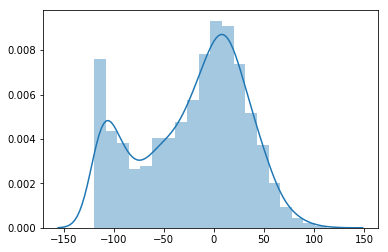

In [108]:
sns.distplot(SVMScoreMin[(df_train[symptom_score]==0).values])

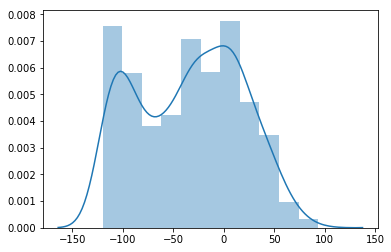

In [109]:
sns.distplot(SVMScoreMin[(df_train[symptom_score]>0).values])

In [110]:
sscores=pd.DataFrame(data={'SVMScoreMin':SVMScoreMin}) 

In [111]:
sscores.head()

,SVMScoreMin
0,-67.348191
1,-29.827395
2,-59.446536
3,-58.514193
4,2.776013


In [112]:
#save the sscores
sscores.to_csv('Brady_Train_SScores.csv',index=False)

In [116]:
Metadata=pd.read_csv('metadfnum_train_brady.csv')
sscores.index=Metadata.index
X = pd.concat((Metadata,sscores[['SVMScoreMin']]),axis=1)

Test the score of the features

In [117]:
#the matrix of features (drop Patient col)
X.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration,SVMScoreMin
0,17286028,0,2,1,0,0,1,1,1.022774,-67.348191
1,17286030,1,2,1,0,0,1,0,1.022774,-29.827395
2,17286034,0,2,1,0,1,1,1,6.714734,-59.446536
3,17286036,1,2,1,0,1,1,0,6.714734,-58.514193
4,17286042,1,2,1,0,2,1,0,-0.874546,2.776013


In [118]:
X.drop(['patient'],axis=1).to_csv("./Submissions/Submission_Brady_Train.csv",index=False)

**Baseline model (use only metadata and duration)**

In [119]:
Metadata.drop(['patient'],axis=1).to_csv('./Submissions/Baseline_Brady_Train.csv',index=False)

In [121]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' './Submissions/Baseline_Brady_Train.csv'

Welcome, Luca Lonini!

AUPRC: 0.823


In [124]:
%run sc2FitModels_LOSOCV.py 'dyskinesia' './Submissions/Baseline_Dysk_Train.csv'

Welcome, Luca Lonini!

AUPRC: 0.356


** SScore Model** 

In [122]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' './Submissions/SScores_Brady_Train.csv'

Welcome, Luca Lonini!

AUPRC: 0.828


In [123]:
%run sc2FitModels_LOSOCV.py 'dyskinesia' './Submissions/SScore_Dysk_Train.csv'

Welcome, Luca Lonini!

AUPRC: 0.569


### Train the SVM model on all train data (to run on Test set)

In [35]:
Train = pd.DataFrame(NAFeat.values)
TrainScores = Scores

#standardize features
scaler = StandardScaler()
Train.iloc[:,6:]=scaler.fit_transform(Train.iloc[:,6:])
ZScoreID = TrainScores==0

#train svm on 0 scores instances
svc = OneClassSVM(kernel='rbf', nu=.2) # dyskinesia (nu=0.2)
svc.fit(Train.values[ZScoreID,:])

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.2, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

### Compute (predict) scores on Test Data

In [42]:
#load test data features
# filename = './WindowedFeatures/Dysk_Unnorm_Train.pkl'
filename = './WindowedFeatures/Dysk_Unnorm_Test.pkl'

f = open(filename,'rb')
F = pickle.load(f)
f.close()

#unpack
Features = F['Features']
DataFiles = F['DataFiles']
Scores = F['Scores']
Subjs = F['Subjs']
flist = F['flist']

In [43]:
len(Features)

5134

In [138]:
SVMScores = svc.decision_function(NAFeat_Test.values) 

In [142]:
len(IDs)

643

In [144]:
IDs.head()

,dataFileHandleId
12963_10,17287647
12965_10,17287654
12968_10,17287666
12970_10,17287674
12975_10,17287694


In [161]:
SVMScores = pd.DataFrame(data=DataFiles,columns=['FileID'])
SVMScores['SVMScore']=0
# SVMScores = pd.DataFrame(np.zeros((len(NAFeat_Test))))
# SVMScores['FileID']=DataFiles

In [62]:
SVMScores.head()

,FileID,SVMScore
0,17287647,62.446290
1,17287647,67.391817
2,17287647,61.948787
3,17287647,65.592535
4,17287647,52.221862


In [64]:
NAFeat_Test = pd.DataFrame(Features,columns=flist).dropna() #remove nan rows from feature set (if any)
SVMScores = pd.DataFrame(data=DataFiles,columns=['FileID'])
SVMScores['SVMScore']=0

#standardize features
NAFeat_Test.iloc[:,6:] = scaler.transform(NAFeat_Test.iloc[:,6:])
# compute SVM scores for each window
SVMScores['SVMScore'] = svc.decision_function(NAFeat_Test.values) 

#the minimum SVM score across windows for each record 
SVMScoreMin = [] 
DataFiles = pd.Series(DataFiles)
IDs = pd.DataFrame(df_test.dataFileHandleId)

for row in IDs.itertuples():
    index = DataFiles == row[1]
    if not any(index):
        continue
    SVMScoreMin.append(np.min(SVMScores.SVMScore[index]))

In [65]:
#convert them to 1D numpy array
SVMScoreMin=np.squeeze(SVMScoreMin)

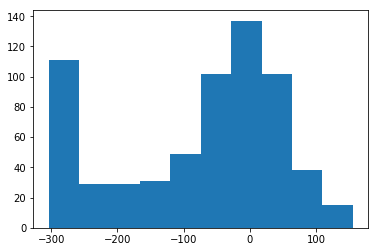

In [73]:
# SVMScores.SVMScore.hist()
ax = plt.hist(SVMScoreMin)

In [79]:
sscores=pd.DataFrame(data={'SVMScoreMin':SVMScoreMin}) 

In [80]:
sscores.head()

,SVMScoreMin
0,15.426238
1,-19.908595
2,48.667445
3,-94.018119
4,-31.861763


In [81]:
#save the sscores
sscores.to_csv('Dysk_Test_SScores.csv',index=False)

In [83]:
Metadata = pd.read_csv('metadfnum_test_dysk.csv')
Metadata.index = df_test.index
sscores.index=Metadata.index
X = pd.concat((Metadata,sscores[['SVMScoreMin']]),axis=1)

## Generate Train and Test Submission

In [87]:
SScores_train = pd.read_csv('Dysk_Train_SScores.csv')
SScores_test = pd.read_csv('Dysk_Test_SScores.csv')

In [88]:
#take the minimum score (farthest window from hyperplane)
SScores_train = SScores_train[['SVMScoreMin']]
SScores_test = SScores_test[['SVMScoreMin']]

In [89]:
#attach metadata
Meta_train = pd.read_csv('metadfnum_train_dysk.csv')
Meta_test = pd.read_csv('metadfnum_test_dysk.csv')

In [90]:
Meta_train = Meta_train.drop('patient',axis=1)
Meta_test = Meta_test.drop('patient',axis=1)

In [91]:
#concatenate metadata and SScores
SScores = pd.concat((SScores_test,SScores_train),axis=0)

In [92]:
X_dysk = pd.concat((Meta_test,Meta_train),axis=0)

In [94]:
X_dysk = pd.concat((X_dysk,SScores),axis=1)

In [95]:
X_dysk.head()

,dataFileHandleId,device,session,site,task,visit,deviceSide,Duration,SVMScoreMin
0,17287647,0,1,0,0,1,1,0.590918,15.426238
1,17287654,0,1,0,1,1,1,-0.747253,-19.908595
2,17287666,1,1,0,2,1,0,0.590918,48.667445
3,17287674,1,1,0,3,1,0,-0.747253,-94.018119
4,17287694,0,1,0,4,1,1,0.590918,-31.861763


In [96]:
X_dysk.to_csv('./Submissions/Submission_Dysk.csv',index=False)

# Solution 2 
## Stacking classifiers using LOSOCV and metafeatures as inputs
Use output posterior probability from each classifier as feature for the classification 

In [104]:
X_meta_train = pd.read_csv('metadfnum_train_brady.csv')
X_meta_train.index = df_train.index
#drop patient as metafeatures and store for LOSOCV 
groups_train = X_meta_train.patient.values
X_meta_train=X_meta_train.drop('patient',axis=1) #DROP PATIENT

In [105]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='rbf',C=1,cache_size=800,probability=True,random_state=3),
          XGBClassifier(n_estimators=150,subsample=1,learning_rate=0.5,max_depth=2)
         ]
model_name = ['Random Forest','Gradient Boosting','SVM','XGB']

In [106]:
len(X_meta_train)

2913

In [107]:
X_meta_train.head(2)

,dataFileHandleId,device,session,site,task,visit,deviceSide,Duration
25819_22,17286028,0,1,0,0,1,1,1.022774
25820_22,17286030,1,1,0,0,1,0,1.022774


In [108]:
#create dataframe to store posterior scores from each clf
Fnew = X_meta_train.copy()
Fnew=Fnew[['dataFileHandleId']]
for m in model_name:
    Fnew[m]=0
Fnew.index=range(len(Fnew)) #reindex array
Fnew.head()

,dataFileHandleId,Random Forest,Gradient Boosting,SVM,XGB
0,17286028,0,0,0,0
1,17286030,0,0,0,0
2,17286034,0,0,0,0
3,17286036,0,0,0,0
4,17286042,0,0,0,0


In [109]:
#LOSO CV - Compute prediction posteriors from each classifier and aggregate
# X = X_meta_train.iloc[:,1:].as_matrix() #drop fileid 
# y = df_train['bradykinesiaScore'].values

m = zip(models,model_name)
Fnew = LOSOCV(X_meta_train.iloc[:,1:].as_matrix(),y_train,groups_train,m,Fnew)

Training Random Forest
Random Forest, mean F1 on training set = 0.894 (+/- 0.003)
Random Forest, mean Prec = 0.624 (+/- 0.131)
Random Forest, mean Rec = 0.609 (+/- 0.144)
Training Gradient Boosting
Gradient Boosting, mean F1 on training set = 0.760 (+/- 0.005)
Gradient Boosting, mean Prec = 0.881 (+/- 0.076)
Gradient Boosting, mean Rec = 0.542 (+/- 0.164)
Training SVM


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVM, mean F1 on training set = 0.759 (+/- 0.005)
SVM, mean Prec = 0.801 (+/- 0.139)
SVM, mean Rec = 0.531 (+/- 0.169)
Training XGB
XGB, mean F1 on training set = 0.791 (+/- 0.005)
XGB, mean Prec = 0.783 (+/- 0.121)
XGB, mean Rec = 0.603 (+/- 0.155)


## Make submission

In [110]:
Fnew.head()

,dataFileHandleId,Random Forest,Gradient Boosting,SVM,XGB
0,17286028,0.006667,0.087325,0.093792,0.026341
1,17286030,0.010000,0.084324,0.085097,0.023234
2,17286034,0.900000,0.820659,0.960686,0.586292
3,17286036,0.870000,0.814961,0.943490,0.489512
4,17286042,0.012500,0.251301,0.117062,0.142725


In [129]:
#add patient column (WILL BE REMOVED LATER FOR FINAL SUBMISSION)
# X_meta['patient']=groups

In [112]:
Fnew.index=X_meta_train.index

In [113]:
#concatenate metadata features and stacking output dataframes
X = pd.concat((X_meta_train,Fnew.iloc[:,1:]),axis=1)

In [114]:
X.head()

,dataFileHandleId,device,session,site,task,visit,deviceSide,Duration,Random Forest,Gradient Boosting,SVM,XGB
25819_22,17286028,0,1,0,0,1,1,1.022774,0.006667,0.087325,0.093792,0.026341
25820_22,17286030,1,1,0,0,1,0,1.022774,0.010000,0.084324,0.085097,0.023234
25821_22,17286034,0,1,0,1,1,1,6.714734,0.900000,0.820659,0.960686,0.586292
25822_22,17286036,1,1,0,1,1,0,6.714734,0.870000,0.814961,0.943490,0.489512
25824_22,17286042,1,1,0,2,1,0,-0.874546,0.012500,0.251301,0.117062,0.142725


In [115]:
X.to_csv('Submission_Metaf&Metaf_Stacking.csv',index=False) #store features for training data

** Metadata + Stacked Metadata **

In [116]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_Metaf\&Metaf_Stacking.csv

Welcome, Luca Lonini!

AUPRC: 0.920


** Stacked Metadata only **

In [450]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_Metaf_Stacking.csv

Welcome, Luca Lonini!

AUPRC: 0.868


## Compute features on test data and create Final submission

In [127]:
#load metadata from test and drop patiet
X_meta_test = pd.read_csv('metadfnum_test_brady.csv')
X_meta_test.index = df_test.index #necessary to re-index to aggregate features in Fnew
#drop patient id from test metadata
X_meta_test=X_meta_test.drop('patient',axis=1) #DROP PATIENT

In [129]:
len(X_meta_test)

1367

In [131]:
#train stacked models on all training data 
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='rbf',C=1,cache_size=800,probability=True,random_state=3),
          XGBClassifier(n_estimators=150,subsample=1,learning_rate=0.5,max_depth=2)
         ]
model_name = ['Random Forest','Gradient Boosting','SVM','XGB']
#create dataframe to store posterior scores from each clf
Fnew = X_meta_test.copy()
Fnew=Fnew[['dataFileHandleId']]
for m in model_name:
    Fnew[m]=0
Fnew.index=range(len(Fnew)) #reindex array
#zip models
m = zip(models,model_name)
#train and compute stacking predictions on test set
Fnew_test=testdata_stacking(X_meta_train.iloc[:,1:],y_train,X_meta_test.iloc[:,1:],m,Fnew)

Training Random Forest
Computing prediction Random Forest
Training Gradient Boosting
Computing prediction Gradient Boosting
Training SVM
Computing prediction SVM
Training XGB
Computing prediction XGB


In [136]:
Fnew_test.index=df_test.index

In [137]:
Fnew_test.head()

,dataFileHandleId,Random Forest,Gradient Boosting,SVM,XGB
12959_10,17287630,0.050000,0.121028,0.123628,0.062891
12960_10,17287634,0.080000,0.115793,0.128452,0.051649
12961_10,17287639,0.100000,0.151852,0.099247,0.088959
12962_10,17287642,0.076667,0.145504,0.083337,0.083818
12964_10,17287650,0.310440,0.356194,0.137389,0.251858


In [138]:
len(Fnew_test)

1367

In [139]:
#attach metadata 
X_test = pd.concat((X_meta_test,Fnew_test.iloc[:,1:]),axis=1)

In [140]:
X_test.head()

,dataFileHandleId,device,session,site,task,visit,deviceSide,Duration,Random Forest,Gradient Boosting,SVM,XGB
12959_10,17287630,0,1,0,0,1,1,0.206077,0.050000,0.121028,0.123628,0.062891
12960_10,17287634,1,1,0,0,1,0,0.206077,0.080000,0.115793,0.128452,0.051649
12961_10,17287639,0,1,0,1,1,1,1.740564,0.100000,0.151852,0.099247,0.088959
12962_10,17287642,1,1,0,1,1,0,1.740564,0.076667,0.145504,0.083337,0.083818
12964_10,17287650,1,1,0,2,1,0,-0.848883,0.310440,0.356194,0.137389,0.251858


In [142]:
# create final submission file with features from train and test
X_train = pd.read_csv('Submission_Metaf&Metaf_Stacking.csv')
X_submission = pd.concat((X_test,X_train),axis=0)
X_submission.to_csv('./Submissions/Submission_brady_MetafandMetaf_Stacking.csv',index=False)

In [143]:
len(X_submission)

4280